# <center> Bag of Words Meets Bags of Popcorn </center>
#### <center> movie review classification with CNN </center>
<br><br><br>
<center> by Yujin Jeon </center>

## About the Data

- 50,000 IMDB movie reviews(25000 labeled train, 25000 unlabeled test)
- binary sentiment
    - IMDB rating < 5 : score of 0
    - IMDB rating >=7 : score of 1
- Data Fields
    - id
    - sentiment
    - review

In [24]:
import pandas as pd
import numpy as np
import os
import nltk
import re
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

## EDA

In [3]:
train_data = pd.read_csv('word2vec-nlp-tutorial/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
test_data = pd.read_csv('word2vec-nlp-tutorial/testData.tsv', header=0, delimiter='\t', quoting=3)

In [303]:
train_data.tail()

,id,sentiment,review
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


In [304]:
test_data.tail()

,id,review
24995,"""2155_10""","""Sony Pictures Classics, I'm looking at you! S..."
24996,"""59_10""","""I always felt that Ms. Merkerson had never go..."
24997,"""2531_1""","""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""","""From the opening sequence, filled with black ..."
24999,"""11465_10""","""This is a great horror film for people who do..."


### - word count per review

In [13]:
train_word_counts = train_data['review'].apply(lambda x: len(x.split(' ')))
train_word_counts.head()

0    433
1    158
2    378
3    379
4    367
Name: review, dtype: int64

In [307]:
train_word_counts.describe()

count    25000.000000
mean       233.786240
std        173.745845
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: review, dtype: float64

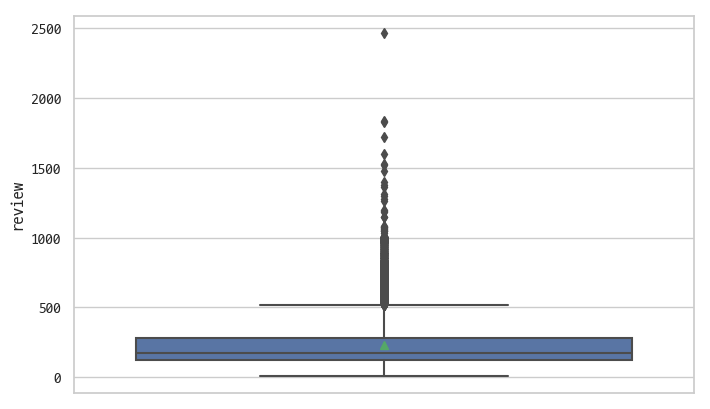

In [308]:
sns.boxplot(train_word_counts, orient='v', showmeans=True)
plt.show()

(-0.5, 799.5, 599.5, -0.5)

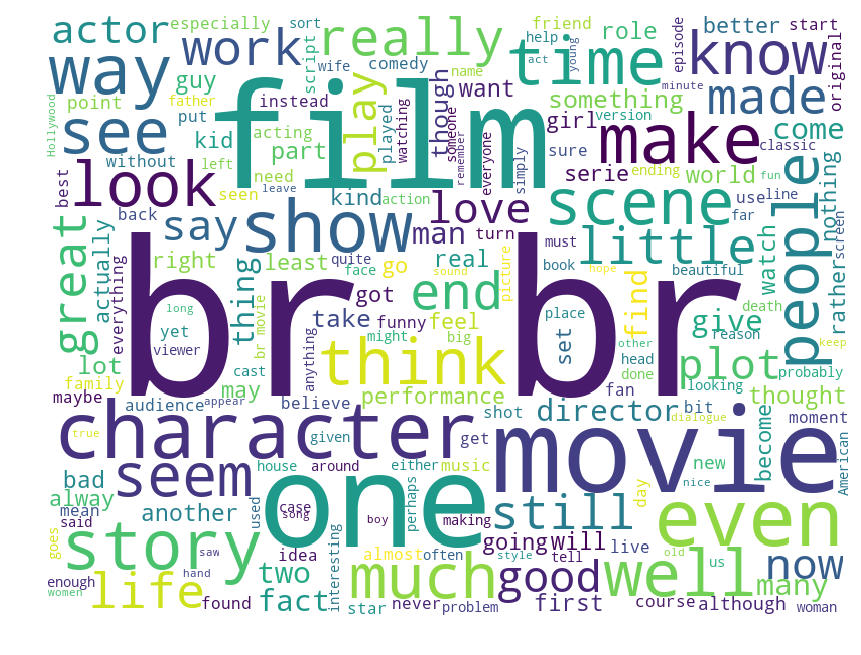

In [313]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(' '.join(train_data['review']))
plt.figure(figsize=(15, 8))
plt.imshow(cloud)
plt.axis('off')

## - Sentiment Ratio

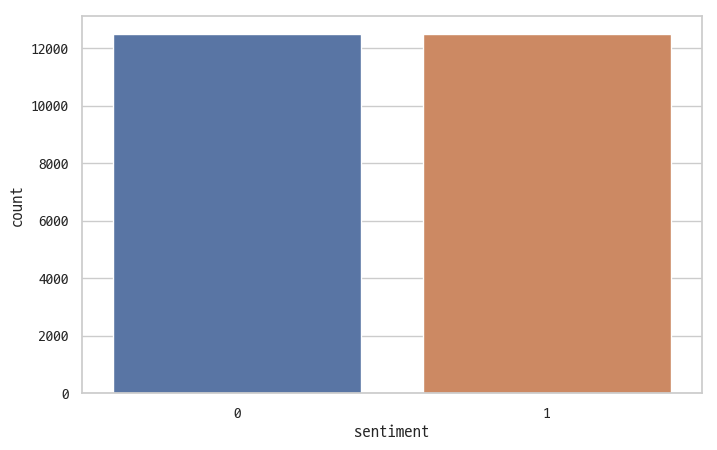

In [4]:
sns.countplot(train_data.sentiment)
plt.show()

In [12]:
train_data.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

## Preprocessing Reviews

In [165]:
def preprocess(df, column, remove_stopwords=False):
    
    df['review_tokenized'] = df[column].apply(lambda x:bs(x, 'html5lib').get_text())
    df['review_tokenized'] = df['review_tokenized'].apply(lambda x:re.sub('[^a-zA-Z]', ' ', x))
    df['review_tokenized'] = df['review_tokenized'].apply(lambda x: x.lower())
    df['review_tokenized'] = df['review_tokenized'].apply(lambda x: nltk.word_tokenize(x))

    stop_words = set(stopwords.words('english'))

    if remove_stopwords:
        df['review_tokenized'] = df['review_tokenized'].apply(lambda x: [w for w in x if w not in stop_words])

    df['review_cleaned'] = df['review_tokenized'].apply(lambda x: ' '.join(x))

    return df

In [166]:
train_df = preprocess(train_data, 'review', remove_stopwords=True)

In [167]:
reviews = train_df.review_cleaned

In [168]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(reviews)

In [169]:
sequences = tokenizer.texts_to_sequences(reviews)

In [170]:
max_len = int(train_word_counts.median())

In [171]:
data = pad_sequences(sequences, maxlen=max_len)

In [172]:
labels = np.asarray(train_data.sentiment)

In [58]:
data.shape, labels.shape

((25000, 174), (25000,))

In [34]:
vocab_size = len(tokenizer.word_index) + 1

In [225]:
pd.Series(list(tokenizer.word_counts.values())).describe()

count    74061.000000
mean        40.338653
std        372.091731
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max      44031.000000
dtype: float64

## Modeling & Training

In [145]:
from keras import Input, Model
from keras.layers import Embedding, Activation, Dense, Conv1D, BatchNormalization, GlobalMaxPool1D, concatenate

In [190]:
input_tensor = Input(shape=(174,))
embedding = Embedding(10000, 32, input_length=174)(input_tensor)

conv1 = Conv1D(100, 3)(embedding)
bn1 = BatchNormalization()(conv1)
relu1 = Activation(activation='relu')(bn1)
pool1 = GlobalMaxPool1D()(relu1)

conv2 = Conv1D(100, 4)(embedding)
bn2 = BatchNormalization()(conv2)
relu2 = Activation(activation='relu')(bn2)
pool2 = GlobalMaxPool1D()(relu2)

conv3 = Conv1D(100, 5)(embedding)
bn3 = BatchNormalization()(conv3)
relu3 = Activation(activation='relu')(bn3)
pool3 = GlobalMaxPool1D()(relu3)

concat = concatenate([pool1, pool2, pool3])

prediction = Dense(1, activation='sigmoid')(concat)

In [191]:
model2 = Model(input_tensor, prediction)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 174)          0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 174, 32)      320000      input_49[0][0]                   
__________________________________________________________________________________________________
conv1d_89 (Conv1D)              (None, 172, 100)     9700        embedding_49[0][0]               
__________________________________________________________________________________________________
conv1d_90 (Conv1D)              (None, 171, 100)     12900       embedding_49[0][0]               
__________________________________________________________________________________________________
conv1d_91 

In [192]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history2 = model2.fit(data, labels, epochs=5, batch_size=512, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 32s 2ms/step - loss: 0.5984 - acc: 0.6725 - val_loss: 0.4407 - val_acc: 0.8116
Epoch 2/5
20000/20000 [==============================] - 29s 1ms/step - loss: 0.2698 - acc: 0.9083 - val_loss: 0.3265 - val_acc: 0.8682
Epoch 3/5
20000/20000 [==============================] - 29s 1ms/step - loss: 0.1598 - acc: 0.9597 - val_loss: 0.2997 - val_acc: 0.8760
Epoch 4/5
20000/20000 [==============================] - 29s 1ms/step - loss: 0.1030 - acc: 0.9836 - val_loss: 0.2981 - val_acc: 0.8760
Epoch 5/5
20000/20000 [==============================] - 29s 1ms/step - loss: 0.0653 - acc: 0.9944 - val_loss: 0.3067 - val_acc: 0.8742


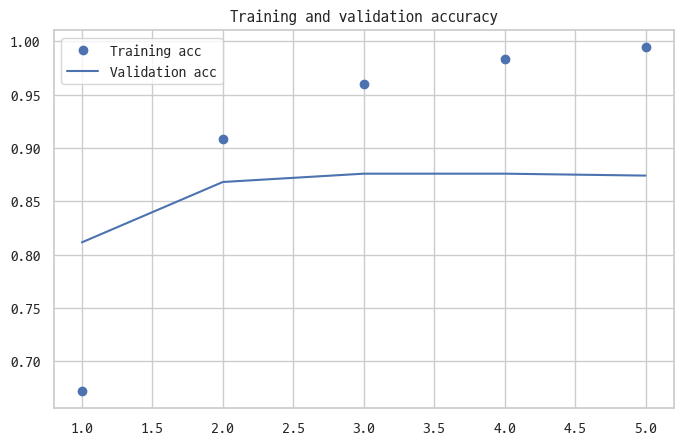

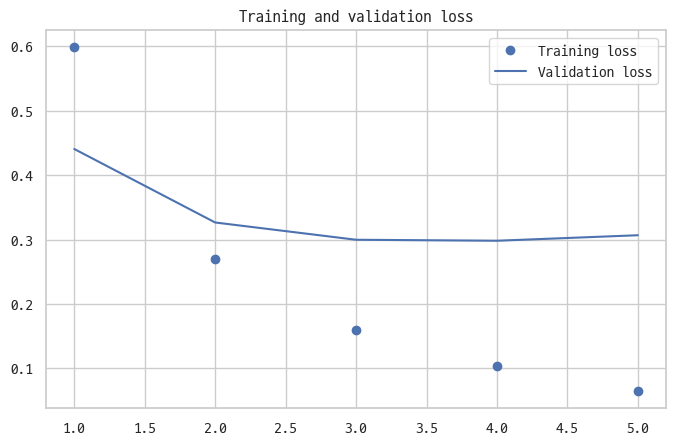

In [193]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Prediction

In [174]:
test_df = preprocess(test_data, 'review', remove_stopwords=True)
test_seq = tokenizer.texts_to_sequences(test_df.review_cleaned)
padded_test_seq = pad_sequences(test_seq, maxlen=max_len)

In [194]:
pred = model2.predict(padded_test_seq)
submission = pd.read_csv('word2vec-nlp-tutorial/sampleSubmission.csv')
submission['sentiment'] = pred
submission.to_csv('submission_cnn3.csv', index=False)


![image](https://user-images.githubusercontent.com/44221498/55778682-75605d80-5ade-11e9-97dd-ffd156ced5d5.png)

